# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & y & v & \theta
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{traction} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to let the simple vehicle travel from one point to another

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.simple_car import SimpleCarDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.01
dynamics = SimpleCarDynamics(dt, min_bounds = -1.0, max_bounds = 1.0)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([2, 1, 1.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
# Q[0, 0] = 1.0
# Q[1, 1] = Q[4, 4] = 0.0
# Q[0, 2] = Q[2, 0] = 1
# Q[2, 2] = Q[3, 3] = 1
Q[0, 0] = 1.0
Q[1, 1] = 6.0
Q[2, 2] = 1.0
Q[3, 3] = 1.0
Q[4, 4] = 1.0

R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 10 * np.eye(dynamics.state_size)
Q_terminal[1,1] = 60

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 300
x0 = dynamics.augment_state(np.array([0.0, 0.0, 1.0, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init,goal_region_radius=0.03, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 1002.6903539760572 [2.5971443  0.98205578 0.87233278 0.01421847]
iteration 1 accepted 955.8552294226793 [2.88385843 1.01709813 0.79044028 0.00567633]
iteration 2 accepted 945.5272097691842 [ 2.86438215  1.02694775  0.81262989 -0.005482  ]
iteration 3 accepted 809.6804797783146 [ 2.81120043  1.01896597  0.81610936 -0.00399743]
iteration 4 accepted 809.4320552586656 [ 2.76808524e+00  1.01279477e+00  8.23953804e-01 -2.72818768e-05]
iteration 5 accepted 800.2440141277324 [2.76876135e+00 1.01126836e+00 8.22368790e-01 1.49940697e-03]
iteration 6 accepted 798.2368017155303 [2.76337438e+00 1.01032260e+00 8.23492291e-01 2.34023063e-03]
iteration 7 accepted 798.0547185957302 [2.76277335 1.00976759 0.82330458 0.00302574]
iteration 8 accepted 797.98882328645 [2.761186   1.00946615 0.8236032  0.003343  ]
iteration 9 accepted 797.934260805359 [2.76103163 1.00928124 0.82353046 0.00361887]
iteration 10 accepted 797.9144140234171 [2.76046263 1.00918482 0.82363944 0.00373489]
iterat

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(xs.shape[0]) * dt
x = xs[:, 0]
y = xs[:, 1]
v = xs[:, 2]
theta = xs[:, 3]
Traction = us[:, 0]
Steering = us[:, 1]

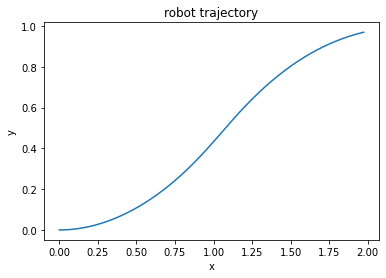

In [12]:
_ = plt.plot(x, y)
_ = plt.xlabel("x")
_ = plt.ylabel("y")
_ = plt.title("robot trajectory")

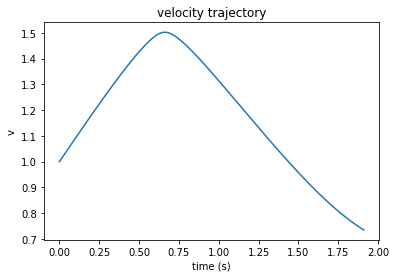

In [13]:
_ = plt.plot(t, v)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("v")
_ = plt.title("velocity trajectory")

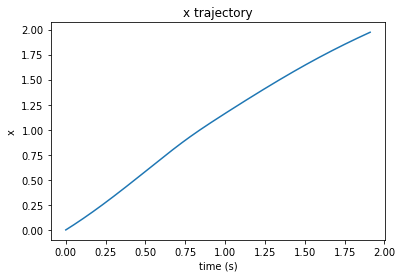

In [14]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("x")
_ = plt.title("x trajectory")

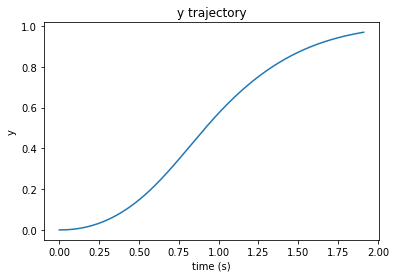

In [15]:
_ = plt.plot(t, y)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("y")
_ = plt.title("y trajectory")

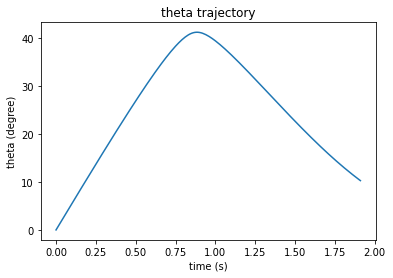

In [16]:
_ = plt.plot(t, theta*180/np.pi)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("theta (degree)")
_ = plt.title("theta trajectory")

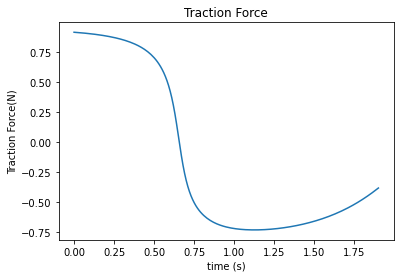

In [17]:
t = np.arange(us.shape[0]) * dt
_ = plt.plot(t, Traction)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Traction Force(N)")
_ = plt.title("Traction Force")

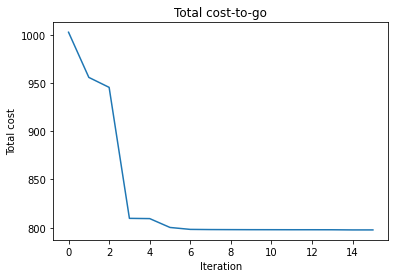

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")